# Final Project: Movie Budgets, Genres, Ratings, and Box Office Performance

This notebook contains the full end-to-end workflow for my IS 477 final project.

The goals of this analysis are to:

- Combine a Rotten Tomatoes ratings dataset with a Kaggle dataset of top-grossing Hollywood films,
- Examine how production budgets relate to domestic box office performance,
- Explore how critic and audience scores relate to box office outcomes,
- Identify which genres tend to generate higher domestic sales,
- Trace how budgets and box office performance have changed over time,

Running this notebook from top to bottom will:

1. Load the raw datasets from `data/raw/`,
2. Clean and integrate them into a single merged dataset,
3. Save the merged data to `data/processed/movies_merged.csv`,
4. Generate all tables and visualizations used in the final report and save them under `results/`.

## 1. Data Loading/Cleaning

In this section, I load the two raw CSV files used in my project:

- `movie_info.csv` (Mendeley Rotten Tomatoes data with critic and audience scores)
- `Highest Holywood Grossing Movies.csv` (Kaggle dataset with budgets, domestic opening, domestic sales, and genres)

Both files are stored in `data/raw/`.

In [17]:
import pandas as pd

Here I prepare the Rotten Tomatoes dataset for integration:

- Rename `title` to `Title` to match the other dataset,
- Extract a four-digit year from the `year_str` string and store it as a numeric `Year`,
- Drop columns that I do not use in the analysis (`url` and `release_date`),
- Drop duplicate rows,
- Remove the trailing `%` from `critic_score` and `audience_score` and convert them to numeric values,
- Drop any rows that still contain missing values after cleaning.

In [18]:
df1 = pd.read_csv('data/raw/movie_info.csv')

df1.rename(columns= {'title': 'Title'}, inplace= True)

df1['Year'] = df1['release_date']
year_str = df1['Year'].astype(str).str.extract(r'(\d{4})', expand= False)
df1['Year'] = pd.to_numeric(year_str, errors= 'coerce').astype('Int64')

df1 = df1.drop(columns= ['url', 'release_date'])

df1 = df1.drop_duplicates(keep= 'first').reset_index(drop= True)

df1[['critic_score','audience_score']] = df1[['critic_score','audience_score']].replace(r'\s*%$', '', regex= True).apply(pd.to_numeric, errors= 'coerce')


df1 = df1.dropna(how= 'any')
df1

,Title,critic_score,audience_score,Year
0,Love Story,63.0,75.0,1970
1,Airport,75.0,54.0,1970
2,M*A*S*H,84.0,83.0,1970
3,Patton,91.0,93.0,1970
5,The Aristocats,64.0,70.0,1970
...,...,...,...,...
10869,Finestkind,29.0,62.0,2023
10870,The Zone of Interest,93.0,78.0,2023
10872,Aquaman and the Lost Kingdom,33.0,81.0,2023
10875,The Iron Claw,100.0,100.0,1916


Next, I clean the Mendeley dataset:

- Drop columns that are not needed for this project (`Distributor`, `International Sales (in $)`, `World Wide Sales (in $)`, `Running Time`, `License`, `Movie Info`, `Unnamed: 0`, `Release Date`),
- Remove duplicate rows,
- Strip dollar signs and commas from `Budget (in $)` and `Domestic Opening (in $)` and convert them to numeric types,
- Drop any rows with missing values afterwards.

In [19]:
df2 = pd.read_csv('data/raw/Highest Holywood Grossing Movies.csv')

df2 = df2.drop(columns= ['Distributor', 'International Sales (in $)', 'World Wide Sales (in $)', 'Running Time', 'License', 'Movie Info', 'Unnamed: 0', 'Release Date'])

df2 = df2.drop_duplicates(keep= 'first').reset_index(drop= True)

df2['Budget (in $)'] = df2['Budget (in $)'].astype(str).str.replace(r'[$,]','',regex= True).str.strip()
df2 = df2[df2['Budget (in $)'].str.match(r'^-?\d+(?:\.\d+)?$')].reset_index(drop= True);df2['Budget (in $)'] = pd.to_numeric(df2['Budget (in $)'],errors= 'coerce')

df2['Domestic Opening (in $)']=df2['Domestic Opening (in $)'].astype(str).str.replace(r'[$,]','',regex=True).str.strip()
df2 = df2[df2['Domestic Opening (in $)'].str.match(r'^-?\d+(?:\.\d+)?$')].reset_index(drop= True);df2['Domestic Opening (in $)'] = pd.to_numeric(df2['Domestic Opening (in $)'],errors= 'coerce')

df2 = df2.dropna(how= 'any')
df2

,Title,Year,Budget (in $),Domestic Opening (in $),Domestic Sales (in $),Genre
0,Avatar,2009,237000000,77025481,785221649,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']"
1,Avengers: Endgame,2019,356000000,357115007,858373000,"['Action', 'Adventure', 'Drama', 'Sci-Fi']"
2,Titanic,1997,200000000,28638131,674292608,"['Drama', 'Romance']"
3,Star Wars: Episode VII - The Force Awakens,2015,245000000,247966675,936662225,"['Action', 'Adventure', 'Sci-Fi']"
4,Jurassic World,2015,150000000,208806270,653406625,"['Action', 'Adventure', 'Sci-Fi']"
...,...,...,...,...,...,...
758,The Scorpion King,2002,60000000,36075875,91047077,"['Action', 'Adventure', 'Fantasy']"
759,Sweet Home Alabama,2002,30000000,35648740,127223418,"['Comedy', 'Romance']"
760,Daddy's Home 2,2017,69000000,29651193,104029443,['Comedy']
761,Hacksaw Ridge,2016,40000000,15190758,67209615,"['Biography', 'Drama', 'History', 'War']"


Now I merge the two cleaned datasets on:

- `Title`
- `Year`

The result is a single DataFrame that contains ratings (critic and audience scores), budgets, domestic opening, domestic sales, and genres for each film. I save the merged dataset to `data/processed/movies_merged.csv` for reuse.

In [20]:
df = pd.merge(df1, df2, on=['Title', 'Year'])
df

,Title,critic_score,audience_score,Year,Budget (in $),Domestic Opening (in $),Domestic Sales (in $),Genre
0,The Godfather,97.0,98.0,1972,6000000,302393,136381073,"['Crime', 'Drama']"
1,The Longest Yard,31.0,62.0,2005,82000000,47606480,158119460,"['Comedy', 'Crime', 'Sport']"
2,Open Season,49.0,57.0,2006,85000000,23624548,85105259,"['Adventure', 'Animation', 'Comedy', 'Family']"
3,Jaws,97.0,90.0,1975,7000000,7061513,265859065,"['Adventure', 'Mystery', 'Thriller']"
4,A Star Is Born,90.0,80.0,2018,36000000,42908051,215333122,"['Drama', 'Music', 'Romance']"
...,...,...,...,...,...,...,...,...
534,Ford v Ferrari,92.0,98.0,2019,97600000,31474958,117624357,"['Action', 'Biography', 'Drama', 'Sport']"
535,Knives Out,97.0,92.0,2019,40000000,26769548,165363234,"['Comedy', 'Crime', 'Drama', 'Mystery', 'Thril..."
536,Bad Boys for Life,75.0,96.0,2020,90000000,62504105,206305244,"['Action', 'Comedy', 'Crime', 'Thriller']"
537,Dolittle,15.0,76.0,2020,175000000,21844045,77047065,"['Adventure', 'Comedy', 'Family', 'Fantasy']"


In [21]:
df.to_csv('data/processed/movies_merged.csv', index=False)

# Research Question 1: Do movies with higher production budgets tend to gross higher in the box office?

To explore this question, I

- Create a scatterplot of `Budget (in $)` vs. `Domestic Sales (in $)`,
- Compute the Pearson correlation between these two variables.

The plot is saved to `results/figures/budget_vs_sales.png` and the correlation is reported below.

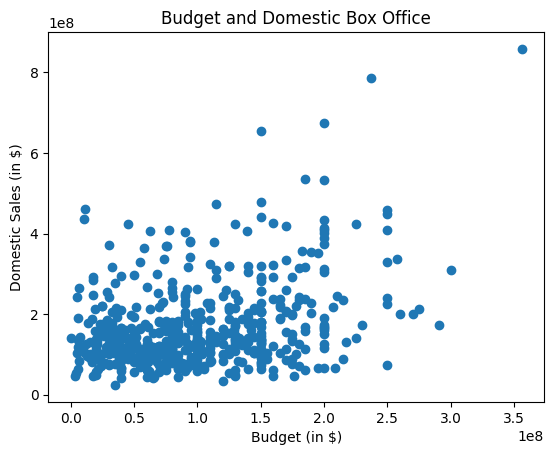

,Budget (in $),Domestic Sales (in $)
Budget (in $),1.000000,0.362163
Domestic Sales (in $),0.362163,1.000000


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

plt.scatter(df['Budget (in $)'], df['Domestic Sales (in $)'])
plt.xlabel("Budget (in $)")
plt.ylabel("Domestic Sales (in $)")
plt.title("Budget and Domestic Box Office")
plt.savefig("results/figures/budget_vs_sales.png", bbox_inches="tight")
plt.show()

df[['Budget (in $)', 'Domestic Sales (in $)']].corr()

# 2. How strongly do ratings correlate with box office performance?

The original proposal mentioned IMDb ratings, but due to changes along the way, in practice, my merged dataset contains Rotten Tomatoes ratings:

- `critic_score` – critic ratings (percentage)
- `audience_score` – audience ratings (percentage)

I examine the relationship between these scores and domestic sales by

- Plotting scatterplots of `critic_score` vs `Domestic Sales (in $)` and `audience_score` vs `Domestic Sales (in $)`,
- Computing correlations for each pair.

The plots are saved under `results/figures/critic_vs_sales.png` and `results/figures/audience_vs_sales.png`.


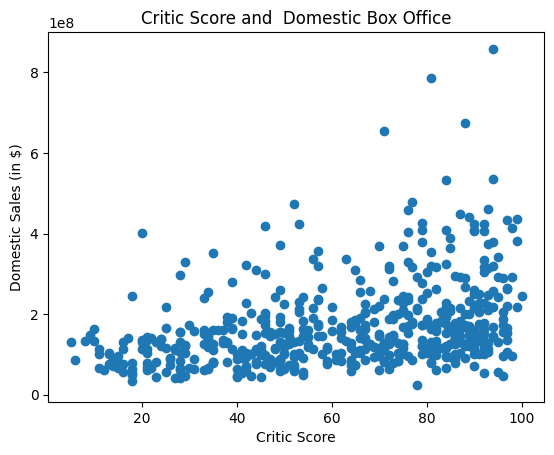

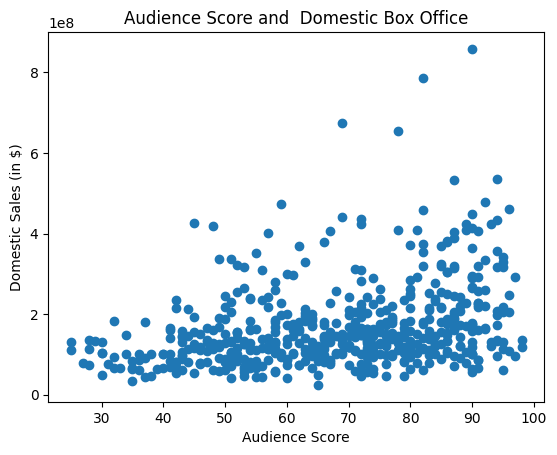

(                       critic_score  Domestic Sales (in $)
 critic_score               1.000000               0.356411
 Domestic Sales (in $)      0.356411               1.000000,
                        audience_score  Domestic Sales (in $)
 audience_score                1.00000                0.33451
 Domestic Sales (in $)         0.33451                1.00000)

In [23]:
plt.scatter(df['critic_score'], df['Domestic Sales (in $)'])
plt.xlabel("Critic Score")
plt.ylabel("Domestic Sales (in $)")
plt.title("Critic Score and  Domestic Box Office")
plt.savefig("results/figures/critic_vs_sales.png", bbox_inches="tight")
plt.show()

plt.scatter(df['audience_score'], df['Domestic Sales (in $)'])
plt.xlabel("Audience Score")
plt.ylabel("Domestic Sales (in $)")
plt.title("Audience Score and  Domestic Box Office")
plt.savefig("results/figures/audience_vs_sales.png", bbox_inches="tight")
plt.show()

df[['critic_score','Domestic Sales (in $)']].corr(), df[['audience_score','Domestic Sales (in $)']].corr()

# 3. Are certain genres more likely than others to produce films that will gross high at the box office?

Each movie can belong to multiple genres. To study genre performance, I

1. "Explode" the `Genre` column so each (movie, genre) combination gets its own row,
2. Compute the average `Domestic Sales (in $)` per genre,
3. Sort genres by average domestic sales in descending order,
4. Produce a horizontal bar chart of average domestic sales by genre.

The bar chart is saved as `results/figures/genre_sales.png` and the table is stored as `results/tables/genre_sales.csv`.

In [24]:
import ast
df['Genre'] = df['Genre'].apply(ast.literal_eval)

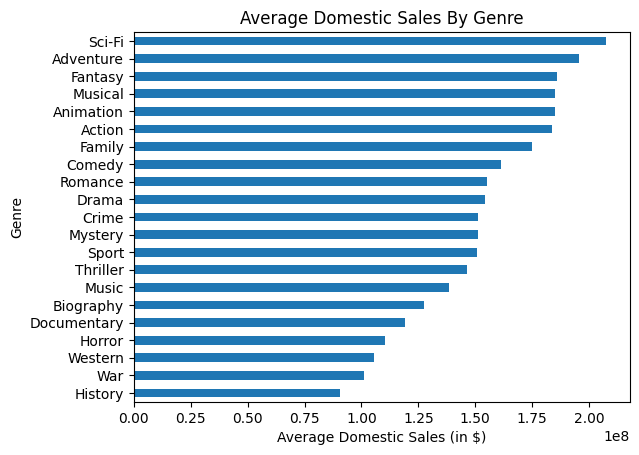

Genre
Sci-Fi         2.074825e+08
Adventure      1.953590e+08
Fantasy        1.859553e+08
Musical        1.851962e+08
Animation      1.851440e+08
Action         1.835719e+08
Family         1.750402e+08
Comedy         1.614896e+08
Romance        1.552429e+08
Drama          1.543178e+08
Crime          1.512710e+08
Mystery        1.511848e+08
Sport          1.507679e+08
Thriller       1.464961e+08
Music          1.383281e+08
Biography      1.272560e+08
Documentary    1.191948e+08
Horror         1.103731e+08
Western        1.055066e+08
War            1.010526e+08
History        9.053484e+07
Name: Domestic Sales (in $), dtype: float64

In [25]:
df_exploded = df.explode('Genre')
genre_sales = (df_exploded.groupby('Genre')['Domestic Sales (in $)'].mean().sort_values(ascending=False))
genre_sales.to_csv("results/tables/genre_sales.csv")

genre_sales.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Average Domestic Sales (in $)")
plt.title("Average Domestic Sales By Genre")
plt.savefig("results/figures/genre_sales.png", bbox_inches="tight")
plt.show()
genre_sales

# 4. How have movie budgets and box office performance changed over time?

To study temporal trends, I

- Compute the average `Budget (in $)` by `Year`,
- Compute the average `Domestic Sales (in $)` by `Year`,
- Plot both time series to see how budgets and domestic sales evolve across decades.

The plots are saved under

- `results/figures/budget_over_time.png`
- `results/figures/sales_over_time.png`.

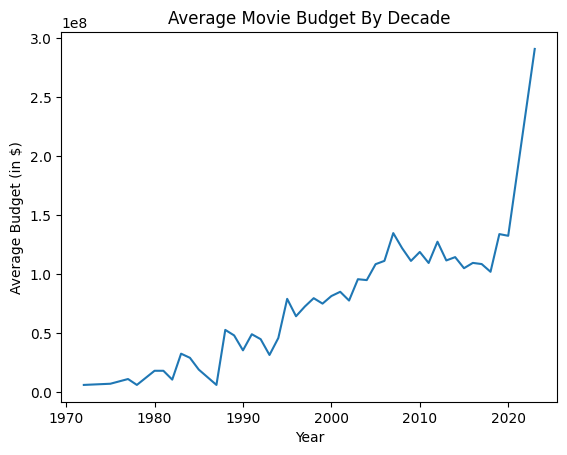

Year
1972    6.000000e+06
1975    7.000000e+06
1977    1.100000e+07
1978    6.000000e+06
1980    1.800000e+07
1981    1.800000e+07
1982    1.050000e+07
1983    3.250000e+07
1984    2.900000e+07
1985    1.900000e+07
1987    6.000000e+06
1988    5.266667e+07
1989    4.800000e+07
1990    3.533333e+07
1991    4.900000e+07
1992    4.480000e+07
1993    3.140000e+07
1994    4.582222e+07
1995    7.900000e+07
1996    6.425000e+07
1997    7.250000e+07
1998    7.957143e+07
1999    7.496105e+07
2000    8.138889e+07
2001    8.500000e+07
2002    7.756522e+07
2003    9.566667e+07
2004    9.491304e+07
2005    1.084118e+08
2006    1.112188e+08
2007    1.347750e+08
2008    1.220000e+08
2009    1.111905e+08
2010    1.187826e+08
2011    1.094286e+08
2012    1.274762e+08
2013    1.115862e+08
2014    1.144038e+08
2015    1.050000e+08
2016    1.095000e+08
2017    1.085200e+08
2018    1.019565e+08
2019    1.339333e+08
2020    1.325000e+08
2023    2.910000e+08
Name: Budget (in $), dtype: float64

In [26]:
year_budget = df.groupby('Year')['Budget (in $)'].mean()

plt.plot(year_budget.index, year_budget.values)
plt.xlabel("Year")
plt.ylabel("Average Budget (in $)")
plt.title("Average Movie Budget By Decade")
plt.savefig("results/figures/budget_over_time.png", bbox_inches="tight")
plt.show()
year_budget

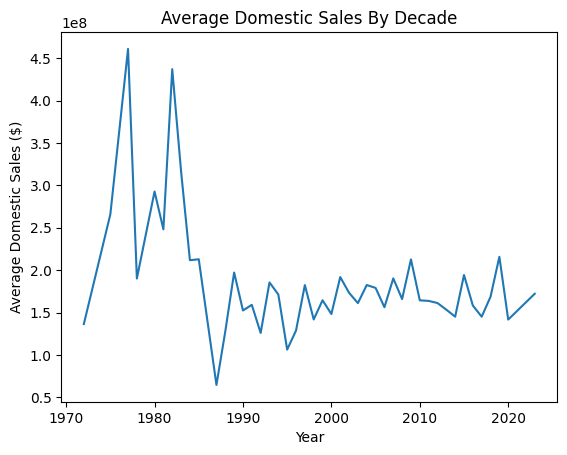

Year
1972    1.363811e+08
1975    2.658591e+08
1977    4.609985e+08
1978    1.900711e+08
1980    2.927540e+08
1981    2.481600e+08
1982    4.371413e+08
1983    3.165661e+08
1984    2.117245e+08
1985    2.128368e+08
1987    6.457724e+07
1988    1.276645e+08
1989    1.971718e+08
1990    1.524320e+08
1991    1.590405e+08
1992    1.259207e+08
1993    1.855067e+08
1994    1.712694e+08
1995    1.062222e+08
1996    1.287266e+08
1997    1.824000e+08
1998    1.418267e+08
1999    1.644576e+08
2000    1.482158e+08
2001    1.918328e+08
2002    1.732533e+08
2003    1.611107e+08
2004    1.824209e+08
2005    1.790536e+08
2006    1.562360e+08
2007    1.902690e+08
2008    1.658818e+08
2009    2.126714e+08
2010    1.643777e+08
2011    1.637172e+08
2012    1.611942e+08
2013    1.533502e+08
2014    1.450803e+08
2015    1.942438e+08
2016    1.582643e+08
2017    1.450454e+08
2018    1.686120e+08
2019    2.157430e+08
2020    1.416762e+08
2023    1.721354e+08
Name: Domestic Sales (in $), dtype: float64

In [27]:
year_sales = df.groupby('Year')['Domestic Sales (in $)'].mean()

plt.plot(year_sales.index, year_sales.values)
plt.xlabel("Year")
plt.ylabel("Average Domestic Sales ($)")
plt.title("Average Domestic Sales By Decade")
plt.savefig("results/figures/sales_over_time.png", bbox_inches="tight")
plt.show()
year_sales